In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import add

Using TensorFlow backend.


In [9]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [10]:
captions  = readTextFile("./dataset/Flickr8k_text/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
print(captions)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
print(len(captions))

40460


In [12]:
#here captions is now a list of 40460 captions
print(captions[40459])
print(captions[1])


997722733_0cb5439472.jpg#4	A rock climber practices on a rock climbing wall .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .


In [13]:
#in every caption we have two thing:- image id and corresponding caption

captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [14]:
first,second  = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [15]:
# Dictionary to Map each Image with the list of captions it has


In [16]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [17]:
#descriptions["1000268201_693b08cb0e"]
descriptions["2513260012_03d33305cf"]

['A black dog is running after a white dog in the snow .',
 'Black dog chasing brown dog through snow',
 'Two dogs chase each other across the snowy ground .',
 'Two dogs play together in the snow .',
 'Two dogs running through a low lying body of water .']

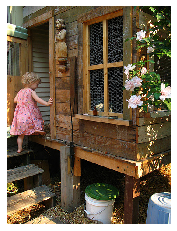

In [18]:
IMG_PATH = "dataset/images/Flicker8k_Dataset/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [19]:
#DATA CLEANING

In [20]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """ 

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)#substitute anything if its not alphabet with space in sentence
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [21]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [22]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [23]:
for key,caption_list in descriptions.items():
    print(key,caption_list)

1000268201_693b08cb0e ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
1001773457_577c3a7d70 ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
1002674143_1b742ab4b8 ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting in front of

181777261_84c48b31cb ['A beach crowded with beachgoers .', 'A busy beach has people scattered on it watching the sky .', 'A partly cloudy day at the beach with people standing around and a building on the right .', 'Beachgoers watch something in the sky .', 'Many people are on the beach , near a building with flags flying .']
1818403842_553a2a392c ['black dogs jump in pool to a hand .', 'Two black dogs are diving into a pool to get a dog toy .', 'Two black dogs jump in a pool .', 'Two black dogs jump into a blue swimming pool .', 'Two dogs are leaping into a swimming pool trying to fetch the yellow toy that is floating in the water .']
1819261140_6c022f4b1d ['A costumed diner sits in a restaurant wearing a black outfit that covers their face .', 'A costumed figure leans into the dinner table .', 'A man dressed in a dark costume sitting at a restaurant table', 'a man sitting at a table with a scary mask covering his face', 'A person at a table , dressed in a black costume .']
1821238649

2208055895_37cd8e1edf ['A boy stands inside a half-completed igloo .', 'A boy wearing winter clothing in an igloo', 'A childing hiding in a snow fort .', 'a man in a stripy hat is standing in a house built from ice that has a pair of boots in the doorway .', 'Child inside of large snow fort .']
2208067635_39a03834ca ['A girl is climbing a rock while someone is filming her .', "A little girl is climbing up a rock as her mom 's shadow is casting over the rock .", 'A small child climbs a large rock while someone casting a shadow takes her picture .', 'A young girl is rock climbing .', 'The long black shadow casts a image on the rock while the young girl climbs the rock .']
2208310655_a3d83080c5 ['a boy is kissing a woman on the cheek next to a girl who is wide eyed and sticking out her tongue .', 'A mother and two children are posing with funny faces .', "An adult with two kids , one child making a face and the other kissing the adult 's cheek .", 'Boy kissing woman and girl sticking out 

2378149488_648e5deeac ['A young boy in a paper crown is sitting in a shopping basket .', 'A young boy is wearing a paper crown while sitting in a grocery cart .', 'Boy with a red crown in a shopping cart .', 'Dark haired child wearing jacket and paper crown while sitting in shopping cart .', 'Kid wearing a paper crown sitting in a shopping cart .']
2378356400_f6bde5d9b3 ['A little girl on a bouncey playground animal sits while a woman takes her picture .', 'A woman and a child .', 'A woman in a checked coat is taking a photograph of a little girl sitting on a fake tiger .', 'A woman stands next to a child who is riding on a toy .', 'The lady takes a picture of the little girl on the ride .']
2379150102_157d718d1d ['A dog pees on the side of a fountain , another dog sniffs the wall , and one is being walked .', 'Several dogs are walking around on a brick street .', 'Three dogs are on a cobblestone road .', 'Three dogs are together outdoors checking out a fountain .', 'three dogs walk ne

2497608431_8dfefc7a1a ['A man plays fetch with his big black dog just out of the woods .', 'A man prepares to throw a stick intended for a black dog in front of him to fetch .', 'A man throwing a stick for his black and tan dog .', 'man throwing stick and dog watching', 'The man in the black jacket is throwing a stick for the dog to chase .']
2498897831_0bbb5d5b51 ['Three children are pulling faces on a purple bench .', 'Three little girls are sitting on a purple bench and making funny faces .', 'Three little girls make silly faces on a wooden swing in an over saturated photo .', 'Three young girls are sitting on a bench swing in a park .', 'Three young girls pose together outside .']
2500354186_0836309cc9 ['A boy walks through a dusty rocky yard with a bicycle tire on his shoulder .', 'A small child is carrying a large hoop .', 'A small child is holding a tire over his shoulder .', 'A very small boy carries a bicycle tire on his shoulder .', 'A young boy is carrying tire rubber down a

2694178830_116be6a6a9 ['An athlete performs the high jump .', 'A woman athlete launching herself over the bar during a pole vault .', 'A woman is black is pole vaulting .', 'A woman pole vaulter upside down as she attempts the vault .', 'a woman with her feet in the air about to do pole vaulting']
2694426634_118566f7ab ['A man and two children in a boat on the water .', 'A man and two children in life jackets in a boat on a lake .', 'A man paddling a rowboat , with two children in back .', 'Man and two kids on a boat on the lake .', 'Two children wearing life jackets face an older male while he paddles the canoe they are sitting in .']
2694890967_7c7a89de16 ['A group of people are laying in the grass under an umbrella .', 'a group of people are sitting under a sunshade in a grassy woodland clearing .', 'A group of picnickers sit under an umbrella .', 'A group of young adult women in bikinis sit in a field of wild grass and flowers , some under a striped umbrella .', 'A group of young w

2833582518_074bef3ed6 ['A dog running down a dirt track .', 'A greyhound running a race .', 'a muzzled greyhound dog is running around a track', 'Greyhound running on track with blue vest with a white numeral two .', 'The # 2 greyhound dog is running around a track .']
2833820456_143ea6ce47 ['A girl about to eat watermelon and drink juice .', 'a little girl is sitting at a table with a jug of juice and some watermelon slices .', 'A little girl sits at a table outdoors and eats watermelon .', 'A young girl at a card table selling lemonade and watermelon .', 'Young girl sitting at a table selling lemonade and watermelon slices .']
2834103050_512e5b330a ['A beach with people standing on the sand', 'A woman with a green sunshade is passing a sales merchant on the beach .', 'Many people are walking along the beach on a clear day .', 'People dressed in bathing suits , dresses and shorts are on the beach , near an exhibit .', 'People standing on a beach , one under a green umbrella']
28342877

2886411666_72d8b12ce4 ['a black , brown and white dog is running beside a green fence in a grassy garden .', 'A dog is galloping through the grass .', 'A dog runs through a lush , green lawn .', 'A tri-colored dog is running on the green grass .', 'Dog running through grass in fenced in area .']
2886533440_dfa832f2fa ['A man in an orange jacket raising his hands to the sky in the sand .', 'A man in an orange jacket stands on sand with a blue sky background .', 'A man is outside standing on sand with a bright blue sky around him .', 'A man standing on a sand dune and reaching to the sky .', 'Man screaming at the top of a sand dune .']
2886837407_a4510ab1ef ['Two asian children smile while hugging each other .', 'Two children grin and hug each other .', 'Two children hug and smile .', 'Two children smile for the camera .', 'Two kids hugging each other .']
2887103049_a867e74358 ['A boy jumps a skateboard while a man in a suit looks on .', 'A man walks past as a skateboarder flies over the

3006093003_c211737232 ['A man talking on a cellphone is holding a blue banner .', 'A man talks on a cellphone while holding an Obama campaign sign .', 'The man in glasses carrying an Obama poster is talking on a cellphone .', 'The Obama supporter wears a black jacket and brown hat .', 'Yong man with cellphone and goatee holding Obama sign']
3006094603_c5b32d2758 ['A man wearing a Barack Obama shirt smiles for the camera', 'A man wearing an Obama t-shirt and holding a coffee cup .', 'A young man touts an Obama t-shirt .', 'This is a man holding a cup and wearing an Obama t-shirt .', 'This man is wearing a Barack Obama T-shirt and carrying a drink .']
3006095077_1992b677f8 ['A couple of men in hats posing for a picture by a gas station .', 'Two guys wearing jackets .', 'Two men in hats pose together .', 'Two men wearing hats .', 'Two men wearing hats stand together and smile .']
3006217970_90b42e6b27 ['A car sponsored by Riwal is smoking its tires on a wet road .', 'A race car drives alo

3138433655_ea1d59e5b7 ['A child is smiling whilst he is has his hands clasped in front of him .', 'A group of children doing a dance .', 'A group of young people doing a pose .', 'A little boy in a black and white snow costume dances with a group of little girls .', 'Children are dressed in black and white costumes .']
3138504165_c7ae396294 ['A goalie stands in front of the goal at a hockey game .', 'A hockey player guards the goal .', 'A hockey player in a yellow jersey is guarding the goal .', 'An ice hockey goalkeeper wearing yellow is defending the goal .', 'The goaltender is crouching in front of the goal .']
3138562460_44227a35cf ['A brown and white horse runs in the gravel .', 'A brown and white horse runs quickly .', 'a horse runs .', 'A large horse with gear , but no rider .', 'The horse gallops around the field .']
3138746531_f6b816c126 ['A group of people are burning things .', 'Several people read by a campfire at night .', 'Three men in caps sit at fireside near cabin , re

3276475986_66cd9cc7e4 ['Asian women standing near a pole .', 'Several Asian women are standing on the street .', 'The four Asian girls are standing on a street corner , all with book bags on their shoulders .', 'These girls are standing near a street corner with cars in the background .', 'Women stand on the street .']
3276895962_c053263d01 ['A black dog and a brown-and-white dog play in a field .', 'A black dog and a brown and white dog running in the grass .', 'A black dog and a white and brown dog running in a grassy field', 'Two dogs running in a field .', 'Two dogs run through the grass .']
3277162496_dff7eeb59e ['Three dogs playing on grass .', 'three dogs playing together in a grassy field with trees in the background', 'Three dogs play with each other out in the field .', 'Three dogs wrestle in the grass .', 'Two black and one white dog interacting in the grass .']
3277824093_299cbb3138 ['A male teenager rides his skateboard onto a large rock .', 'A man gets a skateboard up on 

3396153660_f729d9f9b9 ['Two brunettes , one with tattoos , hug and smile at camera indoors .', 'Two middle-aged women with tattoos hug each other for the camera .', 'Two women , one with tattoos , hold each other and smile .', 'Two young women posing and holding each other in close-up .', 'Two young women posing for a picture']
3396157719_6807d52a81 ['A brown and white dog on a trampoline with a forest in the background .', 'a brown and white dog with a red collar getting on a trampoline', 'A dog gets on a trampoline .', 'dog with a red collar on a trampoline', 'The brown and white dog is standing on a trampoline with its tongue hanging out .']
3396251819_1efa69310f ['A man wearing red sunglasses is carrying two cameras .', 'A person stands wearing sunglasses , a boat and two cameras .', 'A person wearing a grey jacket and sunglasses poses for the camera .', 'A woman wearing a grey jacket and pink sunglasses', 'The man with a gray jacket and red sunglasses is holding cameras and standi

3504479370_ff2d89a043 ['British police standing at a parade .', 'Police gather .', 'Police in yellow jackets at a protest', 'The police in the neon jackets stood guard against the large crowd .', 'The police officers in bright yellow jackets watch the crowd .']
3504881781_6a842e043b ['A group of men are changing the shells on a cannon .', 'Group of men loading a cannon .', 'several men loading a metal cannon', 'Several people work on a machine .', 'Some men try to load what looks like a cannon .']
3504940491_94c43792ed ['A woman and child fly soar through the air , seated on an amusement park ride .', 'A young girl is on a ride at an amusement park .', 'Smiling little girl on a carnival ride .', 'There is a little girl riding a carnival ride .', 'The young girl enjoys the swing at the carnival .']
350529848_9569a3bcbc ['Dog chases ball in water .', 'Two black dogs playing in surf , one grabbing a red ball off the sand .', 'two black dogs race for a ball on the shore .', 'Two dogs playi

3581451227_618854cea4 ['A flower girl and ring bearer watch the flower petals hit the grass .', 'A flower girl drops petals while the ring bearer watches .', 'A little girl and boy after a wedding in a field', 'A young girl in a yellow dress and a small boy in a white suit .', 'There is a young girl in a yellow dress and a young boy in a white suit standing in a field of grass .']
3581538034_783b7d0d09 ['A dog being held by a harness on a waterboard over splashing water with a tube structure in the background .', 'A man dropping from a rope into the ocean on a board .', 'A man is suspended above water while holding a large ski that is shaped like a skateboard .', 'A water boarder being towed during a jump .', "Waterskier jumps off the water 's surface , unknown structure in background ."]
3581818450_546c89ca38 ['A big light brown dog runs on the green grass .', 'A brown dog is running through green grass .', 'A yellow dog running across a lush green lawn .', 'A yellow dog runs through 

3639967449_137f48b43d ['Two boys are sitting in front of a structure eating Popsicles .', 'Two boys eating popscicles outside .', 'Two boys sitting and eating ice cream .', 'Two little boys are sitting on a step eating ice lollipops .', 'Two young boys eating red and blue popcycles .']
3640020134_367941f5ec ['A black dog running in shallow water on a beach .', 'A black dog runs into the water at the beach .', 'a black dog runs through the water .', 'A dog running in the surf .', 'The dog is playing in the water .']
3640104986_5d8c9a9948 ['A float depicting religious imagery .', 'A religious float is surrounded by people at a street festival .', 'People standing around a monument depicting the crucifixion of Jesus Christ .', 'Several people stand around an elaborate image of the crucified Jesus on a city street .', 'The elaborate Jesus shrine is being carried in a parade .']
3640109324_3ce89e4d1a ['A group of men carry a silver coffin .', 'Men carry a small structure on their shoulders 

3741827382_71e93298d0 ['A boy in a green shirt above something blue .', 'a small boy getting tossed into the air', 'A young boy jumps around on a blue mat with a half-smile on his face .', 'A young boy plays in front of a blue object .', 'The boy wearing the green shirt is climbing on a blue inflatable .']
3744832122_2f4febdff6 ['A boy pitches in a baseball game .', 'A boy winding up for a pitch .', 'A young baseball player winds up to throw the ball .', 'A young person pitches in a baseball game .', 'The baseball player is throwing the ball .']
3745451546_fc8ec70cbd ['A hiker ascends a snowy hill .', 'A man reaches the top of a tall sand dune .', 'A person is hiking to the top of a hill .', 'A person walks up a white sandy hill against the blue sky .', 'The person is wearing shorts and climbing a gray sand hill under a blue sky .']
374567836_3ae12ecffb ['A brown dog with a green ball sit in the snow .', 'A brown fluffy dog lays in the snow with its green ball .', 'A dog sits in the sn

487071033_27e460a1b9 ['A man does skateboard tricks off a ramp while others watch .', 'A skateboarder does a trick for an audience .', 'A skateboarder doing a trick off a quarter pipe .', 'Boy dressed in black is doing a skateboarding jump with a crowd watching .', 'People watching a guy in a black and green baseball cap skateboarding .']
487074671_66db20bf47 ['a man in brown jacket and blue cap is washing a black jacket in fountain .', 'A man leans over into a fountain .', 'a man stares at bricks .', 'A man washing the corner of a jacket in a public fountain .', 'The young man looks into the fountain on a sunny day .']
487487795_54705c406e ['A black and brown dog is playing with a brown and white dog .', 'Two dogs are playing on the grass .', 'Two dogs leap toward each other on a grassy lawn .', 'Two dogs on hind legs with faces near each other on a grassy field .', 'Two dogs playing .']
487894806_352d9b5e66 ['A brown dog wearing a collar is chasing and biting on a red broom .', 'A do

827941668_2e4ac6cb39 ['A child is splashing in the water at the beach .', 'A girl is playing in the ocean at dusk .', 'A kid splashes in the ocean .', 'A person is standing in water with it splashing all around them while another person lingers in the background .', 'Two children playing in the surf .']
832128857_1390386ea6 ['A red haired little boy smiles while swinging .', 'A redheaded child is happily swinging in park .', 'A smiling child is swinging on a swing .', 'Boy playing on the swing .', 'Young Blonde boy on swing set in park']
835415474_7b7f2a9768 ["A baby hangs off an adult 's back while laughing .", 'A child is hanging upside down from an adults shoulders .', "A girl is upside-down on someone 's shoulders .", 'A small child hangs upside down from the back of an adult .', "A small child is hanging upside down from an adult 's shoulder ."]
836768303_d748df5546 ['A small blonde boy and another small child are inside a cushion doghouse with a brown dog .', 'Two children and a 

In [24]:
#  modify all the captions i.e - cleaned captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [25]:
#descriptions["1000268201_693b08cb0e"]
#descriptions["2513260012_03d33305cf"]
print(descriptions.keys())

dict_keys(['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623002_8195a43714'

In [26]:
# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [27]:
#Vocabularydescriptions = None
with open("descriptions.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [28]:
print(type(descriptions))

<class 'dict'>


In [29]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))
print(vocab)

Vocab Size : 8424
{'bamboo', 'apart', 'sleeding', 'sunny', 'dishtowel', 'yet', 'supporting', 'tents', 'sees', 'skiers', 'wheelchair', 'dalmatian', 'faithful', 'gallery', 'hardhat', 'saharan', 'interacts', 'cliffs', 'ractrack', 'dips', 'crowd', 'safron', 'dumps', 'ferris', 'armenian', 'hook', 'wood', 'mingling', 'astonishment', 'mostly', 'wheelbarrow', 'decide', 'completes', 'eldery', 'breaststroke', 'dots', 'these', 'grouped', 'marches', 'earphones', 'heavily', 'mom', 'snowstorm', 'jacket', 'mommy', 'soup', 'rafting', 'strapless', 'wintery', 'passifier', 'fabric', 'domes', 'goth', 'everything', 'bearers', 'collision', 'mart', 'pleasant', 'mike', 'burka', 'herbs', 'midget', 'european', 'outlined', 'harly', 'machine', 'downstream', 'including', 'election', 'horses', 'oversized', 'throat', 'ovals', 'policemen', 'may', 'oval', 'tried', 'fastened', 'seabird', 'weather', 'smooth', 'starring', 'pilot', 'bills', 'homerun', 'nuzzling', 'turkeys', 'flamboyantly', 'housekeeping', 'marble', 'scene

In [30]:
#  ALl words in description dictionary
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))
print(total_words[:15])

Total Words 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [31]:
# Filter Words from the Vocab according to certain threshold frequncy

In [32]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))
print(freq_cnt)

8424
{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'pain

In [33]:
# Sort this dictionary according to the freq count
#sort in increasing order
#a=sorted([1,4,5,8,2,3],reverse=True)
#a
#sorted function operate on list. since freq_cnt was dictionary so to convert it to list, item() fun is used
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [34]:
print(len(total_words))

1845


In [35]:
#Prepare Train/Test Data

In [36]:
train_file_data = readTextFile("dataset/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("dataset/Flickr8k_text/Flickr_8k.testImages.txt")

In [37]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [38]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [39]:
print(type(train))

<class 'list'>


In [40]:
print(train)

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154', '2851304910_b5721199bc', '3423802527_94bd2b23b0', '3356369156_074750c6cc', '2294598473_40637b5c04', '1191338263_a4fa073154', '2380765956_6313d8cae3', '3197891333_b1b0fd1702', '3119887967_271a097464', '2276499757_b44dc6f8ce', '2506892928_7e79bec613', '2187222896_c206d63396', '2826769554_85c90864c9', '3097196395_ec06075389', '3603116579_4a28a932e2', '3339263085_6db9fd0981', '2532262109_87429a2cae', '2076906555_c20dc082db', '2502007071_82a8c639cf', '3113769557_9edbb8275c', '3325974730_3ee192e4ff', '1655781989_b15ab4cbff', '1662261486_db967930de', '2410562803_56ec09f41c', '2469498117_b4543e1460', '69710415_5c2bfb1058', '3414734842_beb543f400', '3006217970_90b42e6b27', '2192411521_9c7e488c5e', '3535879138_9281dc83d5', '2685788323_ceab14534a', '34

In [41]:
print(len(train))

6000


In [42]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [43]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [44]:
#Data Preprocessing - Images

In [45]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [46]:
model_new = Model(model.input,model.layers[-2].output)
#Model(input,output)

In [47]:
def preprocess_image(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

#img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()

In [48]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [49]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")
#len(encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg"))

array([0.06535919, 0.16782546, 0.32517615, ..., 0.05107122, 0.3282121 ,
       1.0043367 ], dtype=float32)

In [92]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [97]:
#encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")
#encode_image(IMG_PATH+"2513260012_03d33305cf.jpg")
#img_id= "2513260012_03d33305cf"
#img_path = IMG_PATH+"/"+img_id+".jpg"
#encode_image(img_path)
print(len(encoding_train.keys()))

6000


In [98]:
!mkdir saved

A subdirectory or file saved already exists.


In [99]:
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [100]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 339.02422761917114


In [101]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [50]:
# Load the train images features from disk

with open("saved/encoded_train_features.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [51]:
print(type(encoding_train))

<class 'dict'>


In [52]:
print(len(encoding_train.keys()))

6000


In [53]:
print(encoding_train["2513260012_03d33305cf"])
#print(encoding_train("2513260012_03d33305cf"))

[0.34707972 0.5115915  0.08728829 ... 1.1897296  0.04043844 0.15271077]


In [54]:
# Load the test images features from disk

with open("saved/encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [55]:
#Data pre-processing for Captions

In [56]:
# Vocab
len(total_words)

1845

In [57]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [58]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [59]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [60]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [61]:
#Data Preparation using Generator Function
print(len(train_descriptions.keys()))
print(train_descriptions)


6000
{'2513260012_03d33305cf': ['startseq black dog is running after white dog in the snow endseq', 'startseq black dog chasing brown dog through snow endseq', 'startseq two dogs chase each other across the snowy ground endseq', 'startseq two dogs play together in the snow endseq', 'startseq two dogs running through low lying body of water endseq'], '2903617548_d3e38d7f88': ['startseq little baby plays croquet endseq', 'startseq little girl plays croquet next to truck endseq', 'startseq the child is playing croquette by the truck endseq', 'startseq the kid is in front of car with put and ball endseq', 'startseq the little boy is playing with croquet hammer and ball beside the car endseq'], '3338291921_fe7ae0c8f8': ['startseq brown dog in the snow has something hot pink in its mouth endseq', 'startseq brown dog in the snow holding pink hat endseq', 'startseq brown dog is holding pink shirt in the snow endseq', 'startseq dog is carrying something pink in its mouth while walking through t

In [62]:
print(len(encoding_train))

6000


In [63]:
print(encoding_train)

{'2513260012_03d33305cf': array([0.34707972, 0.5115915 , 0.08728829, ..., 1.1897296 , 0.04043844,
       0.15271077], dtype=float32), '2903617548_d3e38d7f88': array([0.        , 0.00303405, 0.09360087, ..., 0.43107957, 0.37979567,
       0.9166435 ], dtype=float32), '3338291921_fe7ae0c8f8': array([0.7674464 , 0.5342268 , 0.38325182, ..., 0.02098642, 0.18429342,
       0.04270018], dtype=float32), '488416045_1c6d903fe0': array([6.2481046e-01, 3.2965443e-01, 1.7824222e-04, ..., 1.2753808e+00,
       4.6392539e-01, 4.9036056e-01], dtype=float32), '2644326817_8f45080b87': array([0.11555334, 0.6596538 , 0.0532329 , ..., 0.1439735 , 1.0179377 ,
       0.0055659 ], dtype=float32), '218342358_1755a9cce1': array([1.706183  , 0.4051478 , 0.35206553, ..., 0.2940891 , 0.04833025,
       0.04654434], dtype=float32), '2501968935_02f2cd8079': array([0.10608307, 1.44208   , 0.04447008, ..., 0.20587178, 0.6978759 ,
       1.5904316 ], dtype=float32), '2699342860_5288e203ea': array([0.4612251 , 0.332388

In [64]:
#print(encoding_train("2513260012_03d33305cf"))
key= "2513260012_03d33305cf"
encoding_train[key]

array([0.34707972, 0.5115915 , 0.08728829, ..., 1.1897296 , 0.04043844,
       0.15271077], dtype=float32)

In [65]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [66]:
#Word Embeddings

In [67]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [68]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [69]:
f.close()

In [70]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [71]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [72]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [73]:
#Model Architecture

In [74]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [75]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [76]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [77]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [78]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [79]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [80]:
#Training of Model

In [81]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [82]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

ValueError: could not broadcast input array from shape (103,2048) into shape (103)

In [ ]:
model = load_model("./model_weights/model_9.h5")

In [ ]:
#Predictions

In [ ]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [ ]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()